In [ ]:

import pandas as pd
file_path = 'dblp-v10.csv'
data = pd.read_csv(file_path, on_bad_lines='skip')
data.head(10)

ParserError: Error tokenizing data. C error: EOF inside string starting at row 1422

In [ ]:
!pip install igraph
!pip install louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
file_path = "/content/drive/MyDrive/dblp-v10.csv"
data = pd.read_csv(file_path, on_bad_lines='skip')
print(data.head(10))


                                            abstract  \
0  In this paper, a robust 3D triangular mesh wat...   
1  We studied an autoassociative neural network w...   
2  It is well-known that Sturmian sequences are t...   
3  One of the fundamental challenges of recognizi...   
4  This paper generalizes previous optimal upper ...   
5  Queueing networks with multiple classes of cus...   
6  A CMOS oscillator employing differential trans...   
7  In statistical setting of the pattern recognit...   
8  We first discuss some general aspects of micro...   
9                                                NaN   

                                             authors  n_citation  \
0             ['S. Ben Jabra', 'Ezzeddine Zagrouba']          50   
1  ['Joaquín J. Torres', 'Jesús M. Cortés', 'Joaq...          50   
2           ['Genevi eve Paquin', 'Laurent Vuillon']          50   
3  ['Yaser Sheikh', 'Mumtaz Sheikh', 'Mubarak Shah']         221   
4  ['Efraim Laksman', 'Håkan Lennerstad', '

**PART 1**

In [5]:
import pandas as pd
import numpy as np
import ast
import scipy.stats as stats

data['title_length'] = data['title'].astype(str).apply(len)
def parse_references(ref):
    try:
        return ast.literal_eval(ref) if isinstance(ref, str) else []
    except (SyntaxError, ValueError):
        return []  # Return empty list if parsing fails

data['parsed_references'] = data['references'].apply(parse_references)
id_to_title_length = data.set_index('id')['title_length'].to_dict()
def compute_avg_ref_length(ref_list):
    ref_lengths = [id_to_title_length.get(ref, np.nan) for ref in ref_list]
    return np.nanmean(ref_lengths) if ref_lengths else np.nan

data['avg_ref_title_length'] = data['parsed_references'].apply(compute_avg_ref_length)
filtered_data = data.dropna(subset=['title_length', 'avg_ref_title_length'])
pearson_corr_ref, pearson_p_ref = stats.pearsonr(
    filtered_data['title_length'], filtered_data['avg_ref_title_length']
)

spearman_corr_ref, spearman_p_ref = stats.spearmanr(
    filtered_data['title_length'], filtered_data['avg_ref_title_length']
)

print(f"Pearson Correlation: {pearson_corr_ref:.4f}")
print(f"Spearman Correlation: {spearman_corr_ref:.4f}")


<ipython-input-5-eb72db641388>:24: RuntimeWarning: Mean of empty slice
  return np.nanmean(ref_lengths) if ref_lengths else np.nan  # Use fast numpy mean


Pearson Correlation: 0.2718
Spearman Correlation: 0.2737


 Citation Network (Paper-Paper Network)
 Nodes: Papers, Edges: Citation relationships (from references field)

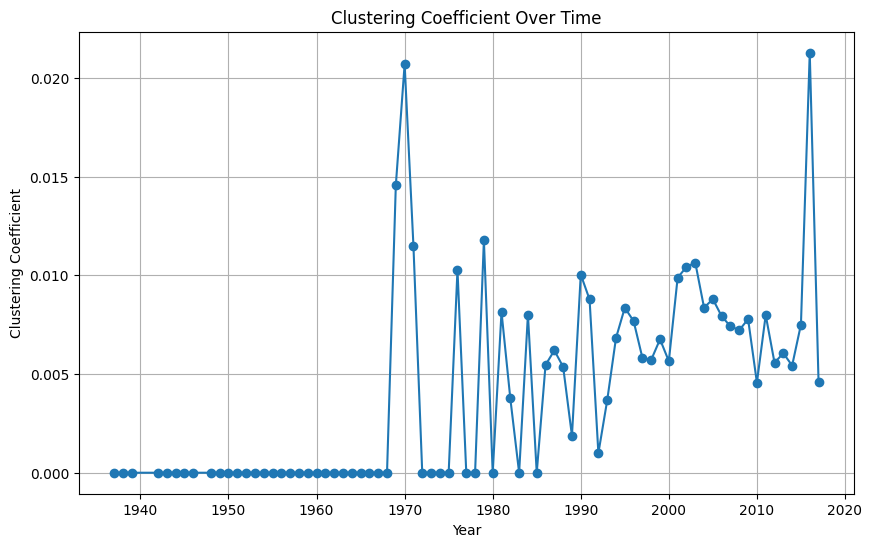

Average Path Length: 11.288044063779358
Diameter: 29
Top 10 Influential Papers by PageRank:
Title: LIBSVM: A library for support vector machines, PageRank Score: 0.0008588822900308434
Title: Distinctive Image Features from Scale-Invariant Keypoints, PageRank Score: 0.0007836097723218891
Title: Random Forests, PageRank Score: 0.0006564163914654092
Title: A fast and elitist multiobjective genetic algorithm: NSGA-II, PageRank Score: 0.0005169899920639979
Title: Probabilistic Reasoning in Intelligent Systems: Networks of Plausible Inference, PageRank Score: 0.0004826549638852427
Title: The WEKA data mining software: an update, PageRank Score: 0.00044723932212597085
Title: Support-Vector Networks, PageRank Score: 0.0004166307323603036
Title: Capacity of multi-antenna Gaussian channels, PageRank Score: 0.00038927801976239274
Title: ImageNet Classification with Deep Convolutional Neural Networks, PageRank Score: 0.0003832014344488105
Title: C4.5: Programs for Machine Learning, PageRank Score:

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import ast
citation_graph = nx.DiGraph()

#nodes
for _, row in data.iterrows():
    paper_id = row['id']
    citation_graph.add_node(paper_id, year=row['year'], title=row['title'])

#edges
for _, row in data.iterrows():
    paper_id = row['id']
    references = row['references']
    try:
        if isinstance(references, str):
            references = ast.literal_eval(references)
        elif not isinstance(references, list):
            references = []
    except (ValueError, SyntaxError):
        references = []

    for ref_id in references:
        if ref_id in citation_graph:
            citation_graph.add_edge(paper_id, ref_id)


clustering_by_year = {}
for year in sorted(data['year'].unique()):
    yearly_nodes = [node for node, attr in citation_graph.nodes(data=True) if attr['year'] == year]
    subgraph = citation_graph.subgraph(yearly_nodes)
    clustering_by_year[year] = nx.average_clustering(subgraph.to_undirected())


plt.figure(figsize=(10, 6))
plt.plot(list(clustering_by_year.keys()), list(clustering_by_year.values()), marker='o')
plt.title('Clustering Coefficient Over Time')
plt.xlabel('Year')
plt.ylabel('Clustering Coefficient')
plt.grid()
plt.show()


if nx.is_strongly_connected(citation_graph):
    avg_path_length = nx.average_shortest_path_length(citation_graph)
    diameter = nx.diameter(citation_graph)
else:
    largest_scc = max(nx.strongly_connected_components(citation_graph), key=len)
    subgraph = citation_graph.subgraph(largest_scc)
    avg_path_length = nx.average_shortest_path_length(subgraph)
    diameter = nx.diameter(subgraph)

print(f"Average Path Length: {avg_path_length}")
print(f"Diameter: {diameter}")

pagerank_scores = nx.pagerank(citation_graph)
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

# Display Top 10 Influential Papers
top_10_papers = [(data[data['id'] == paper_id]['title'].values[0], score)
                 for paper_id, score in sorted_pagerank[:10]]
print("Top 10 Influential Papers by PageRank:")
for title, score in top_10_papers:
    print(f"Title: {title}, PageRank Score: {score}")

 Co-authorship Network (Author-Author Network)
Nodes: Authors, Edges: Co-authorship relationships (if two authors have co-authored a paper,
they are connected)

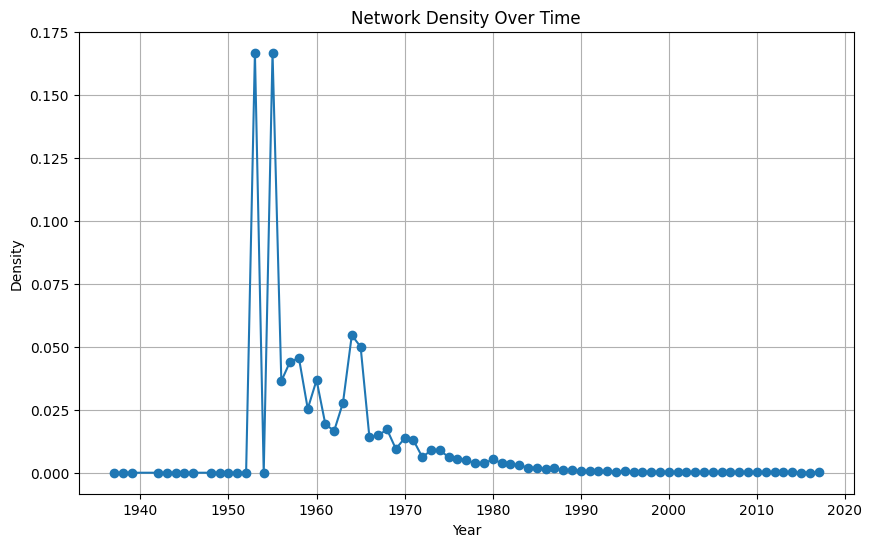

KeyboardInterrupt: 

In [6]:
#In the "closeness" section, it took a long time and eventually resulted in an error. This part was later completed using sampling.
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import ast
from itertools import combinations
from collections import defaultdict
from community import community_louvain


def safe_parse_authors(authors):
    if isinstance(authors, str):
        try:
            return ast.literal_eval(authors) if authors.startswith("[") else []
        except (ValueError, SyntaxError):
            return []
    elif isinstance(authors, list):
        return authors
    return []

data['parsed_authors'] = data['authors'].map(safe_parse_authors)
coauthor_graph = nx.Graph()
for authors, year in zip(data['parsed_authors'], data['year']):
    if len(authors) > 1:
        edges = [(a, b, {"year": year}) for a, b in combinations(authors, 2)]
        coauthor_graph.add_edges_from(edges)
density_by_year = {}
unique_years = sorted(data['year'].unique())

for year in unique_years:
    yearly_nodes = {u for u, v, d in coauthor_graph.edges(data=True) if d["year"] == year}
    yearly_subgraph = coauthor_graph.subgraph(yearly_nodes)
    density_by_year[year] = nx.density(yearly_subgraph)

plt.figure(figsize=(10, 6))
plt.plot(list(density_by_year.keys()), list(density_by_year.values()), marker='o', linestyle='-')
plt.title("Network Density Over Time")
plt.xlabel("Year")
plt.ylabel("Density")
plt.grid()
plt.show()
degree_centrality = nx.degree_centrality(coauthor_graph)
betweenness_centrality = nx.betweenness_centrality(coauthor_graph, normalized=True, k=100)
closeness_centrality = nx.closeness_centrality(coauthor_graph)
def get_top_n(dictionary, n=10):
    return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:n]

top_degree = get_top_n(degree_centrality)
top_betweenness = get_top_n(betweenness_centrality)
top_closeness = get_top_n(closeness_centrality)
print("\nTop 10 Authors by Degree Centrality:")
for author, score in top_degree:
    print(f"Author: {author}, Degree Centrality: {score:.4f}")

print("\nTop 10 Authors by Betweenness Centrality:")
for author, score in top_betweenness:
    print(f"Author: {author}, Betweenness Centrality: {score:.4f}")

print("\nTop 10 Authors by Closeness Centrality:")
for author, score in top_closeness:
    print(f"Author: {author}, Closeness Centrality: {score:.4f}")
partition = community_louvain.best_partition(coauthor_graph)
communities = defaultdict(list)

for author, community_id in partition.items():
    communities[community_id].append(author)
print("\nTop 5 Communities (Louvain):")
for i, (comm_id, members) in enumerate(sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)[:5]):
    print(f"Community {i + 1}: {', '.join(members[:10])}...")  # Print first 10 authors


<ipython-input-9-ceb6be0ddf02>:9: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  from louvain import find_partition


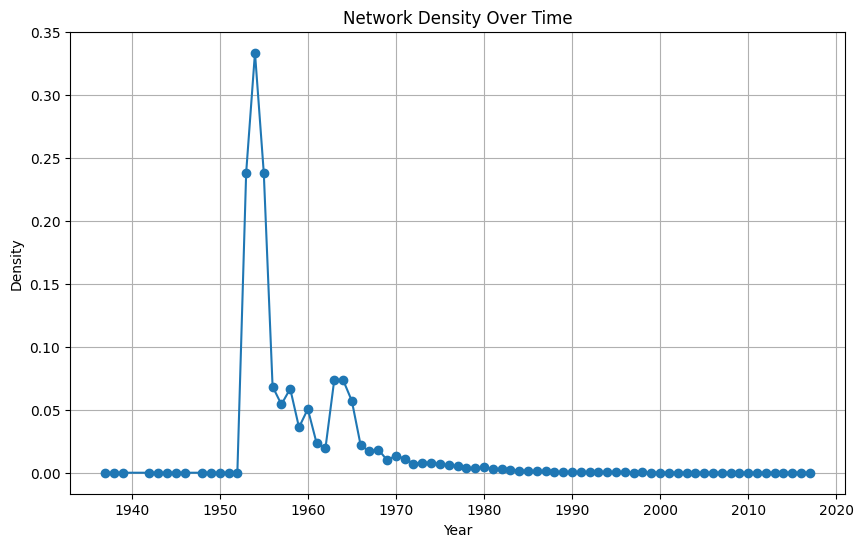

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import ast
!pip install louvain
!pip install igraph
from igraph import Graph
from louvain import find_partition


# Helper function to safely parse authors
def safe_parse_authors(authors):
    if isinstance(authors, str):
        try:
            return ast.literal_eval(authors)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(authors, list):
        return authors
    return []

# Parse authors column
data['parsed_authors'] = data['authors'].apply(safe_parse_authors)

# Create an Undirected Graph for Co-authorship
coauthor_graph = nx.Graph()

# Add edges based on co-authorship using itertools.combinations
for _, row in data.iterrows():
    authors = row['parsed_authors']
    year = row['year']
    if len(authors) > 1:  # Only consider papers with more than one author
        coauthor_graph.add_edges_from(
            [(a, b, {'year': year}) for a, b in combinations(authors, 2)]
        )

# 1. Compute Network Density Per Year
density_by_year = {}
for year in sorted(data['year'].unique()):
    yearly_edges = [(u, v) for u, v, d in coauthor_graph.edges(data=True) if d['year'] == year]
    yearly_graph = nx.Graph()
    yearly_graph.add_edges_from(yearly_edges)
    density_by_year[year] = nx.density(yearly_graph)

# Plot Network Density Over Time
plt.figure(figsize=(10, 6))
plt.plot(list(density_by_year.keys()), list(density_by_year.values()), marker='o')
plt.title('Network Density Over Time')
plt.xlabel('Year')
plt.ylabel('Density')
plt.grid()
plt.show()

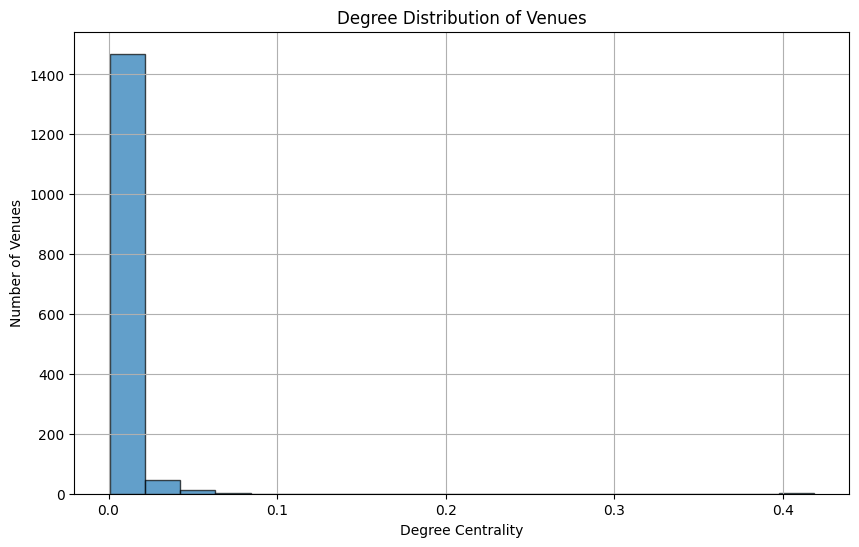


Top 10 Venues by Degree Centrality:
Venue: nan, Degree Centrality: 0.4185
Venue: IEEE Transactions on Pattern Analysis and Machine Intelligence, Degree Centrality: 0.0648
Venue: international conference on computer communications, Degree Centrality: 0.0602
Venue: neural information processing systems, Degree Centrality: 0.0596
Venue: knowledge discovery and data mining, Degree Centrality: 0.0589
Venue: Machine Learning, Degree Centrality: 0.0589
Venue: computer vision and pattern recognition, Degree Centrality: 0.0530
Venue: IEEE Transactions on Signal Processing, Degree Centrality: 0.0524
Venue: Journal of Machine Learning Research, Degree Centrality: 0.0511
Venue: IEEE Journal on Selected Areas in Communications, Degree Centrality: 0.0485

Top 10 Venues by Betweenness Centrality:
Venue: nan, Betweenness Centrality: 0.3366
Venue: human factors in computing systems, Betweenness Centrality: 0.0193
Venue: IEEE Transactions on Pattern Analysis and Machine Intelligence, Betweenness Centra

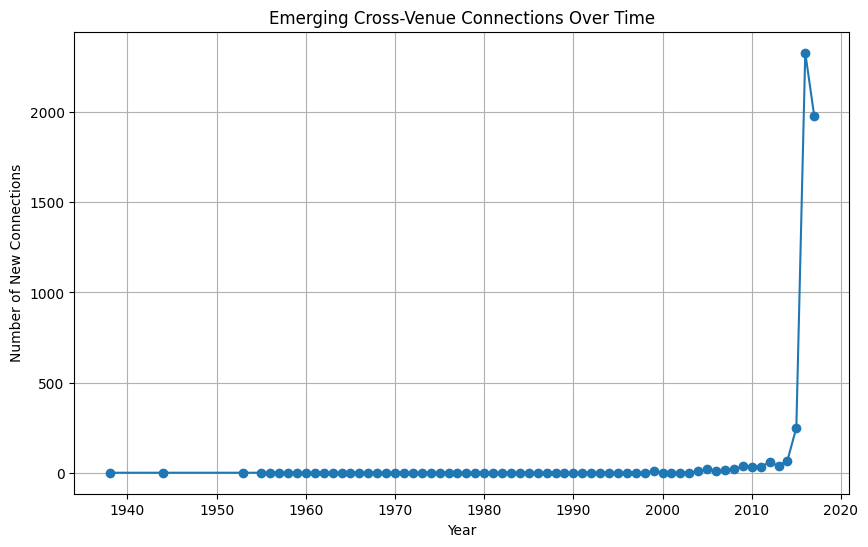

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast
import numpy as np

def safe_parse_references(references):
    if isinstance(references, str):
        try:
            return ast.literal_eval(references)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(references, list):
        return references
    return []
data['parsed_references'] = data['references'].apply(safe_parse_references)


sample_fraction = 0.05
sampled_data = data.sample(frac=sample_fraction, random_state=42)
venue_graph = nx.DiGraph()
ref_dict = sampled_data.set_index("id")["venue"].to_dict()
for _, row in sampled_data.iterrows():
    source_venue = row['venue']
    for ref_id in row['parsed_references']:
        target_venue = ref_dict.get(ref_id, None)
        if target_venue and source_venue != target_venue:  # Only add edges for cross-venue citations
            venue_graph.add_edge(source_venue, target_venue)

degree_distribution = nx.degree_centrality(venue_graph)
degree_values = np.array(list(degree_distribution.values()))


plt.figure(figsize=(10, 6))
plt.hist(degree_values, bins=20, alpha=0.7, edgecolor='black')
plt.title('Degree Distribution of Venues')
plt.xlabel('Degree Centrality')
plt.ylabel('Number of Venues')
plt.grid()
plt.show()
degree_centrality = nx.degree_centrality(venue_graph)
closeness_centrality = nx.closeness_centrality(venue_graph)
num_nodes = len(venue_graph.nodes())
k_value = min(100, num_nodes)
betweenness_centrality = nx.betweenness_centrality(venue_graph, k=k_value)


def get_top_n(dictionary, n=10):
    return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:n]

top_degree = get_top_n(degree_centrality)
top_betweenness = get_top_n(betweenness_centrality)
top_closeness = get_top_n(closeness_centrality)

print("\nTop 10 Venues by Degree Centrality:")
for venue, score in top_degree:
    print(f"Venue: {venue}, Degree Centrality: {score:.4f}")

print("\nTop 10 Venues by Betweenness Centrality:")
for venue, score in top_betweenness:
    print(f"Venue: {venue}, Betweenness Centrality: {score:.4f}")

print("\nTop 10 Venues by Closeness Centrality:")
for venue, score in top_closeness:
    print(f"Venue: {venue}, Closeness Centrality: {score:.4f}")
emerging_connections = {}
for year in sorted(sampled_data['year'].unique()):
    yearly_edges = [
        (u, v) for u, v, d in venue_graph.edges(data=True)
        if sampled_data[sampled_data['venue'] == u]['year'].max() == year
    ]
    emerging_connections[year] = len(yearly_edges)


plt.figure(figsize=(10, 6))
plt.plot(list(emerging_connections.keys()), list(emerging_connections.values()), marker='o')
plt.title('Emerging Cross-Venue Connections Over Time')
plt.xlabel('Year')
plt.ylabel('Number of New Connections')
plt.grid()
plt.show()


Sample Node Attributes:
[('4ab3735c-80f1-472d-b953-fa0557fed28b', {'year': 2008}), ('09cb2d7d-47d1-4a85-bfe5-faa8221e644b', {}), ('10aa16da-3cc8-4af6-9d66-48037e915d76', {}), ('35cb45c3-9408-4096-ab30-bc2e4de3fb5d', {}), ('661a342e-a911-4420-b67d-51c75d3b14e9', {'year': 1999})]


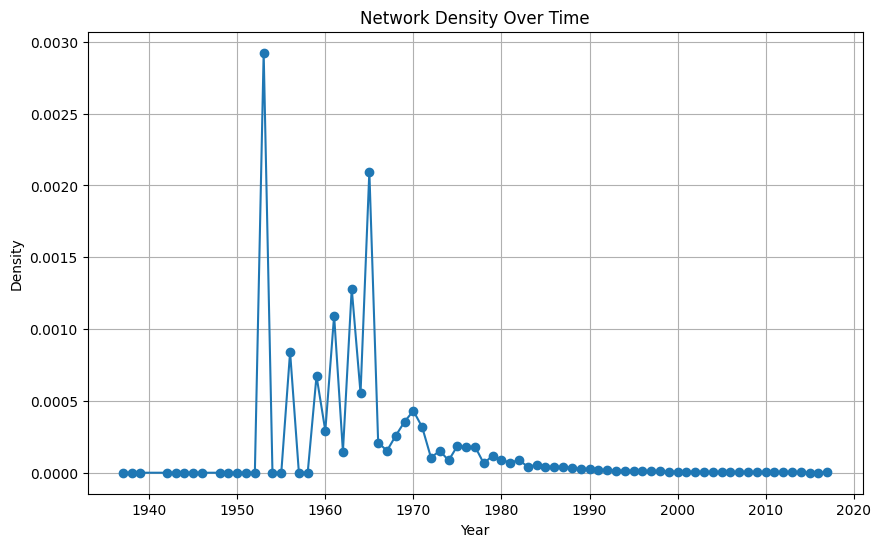


Top Cited Papers:
                                          id  \
332760  b944f77f-113b-4a02-ae5e-d4a124b8fd5b   
358174  c1b6b493-01ef-420f-be44-7bacfe34e846   
442067  dd83785a-dd19-41e3-9b25-ebabbd48d336   
458466  e2f7a74a-8430-4463-94ce-fe85dfd309f9   
716671  f6bd8b64-684d-429a-aab5-8ff3a2c23cd6   
...                                      ...   
299935  ae52cec5-2c8d-4dba-aef4-9bbf25e1896f   
300072  ae60f0b5-6960-4e81-b26d-d7298fd1a9b2   
300082  ae619c93-117a-4ce6-8fa6-e2c38e392796   
300096  ae62ce8b-4cf6-452f-b701-68b2cb625470   
512982  f53b329e-59cc-4141-84dd-8be93b993e08   

                                                    title  in_degree  year  
332760  Distinctive Image Features from Scale-Invarian...       5841  2004  
358174      LIBSVM: A library for support vector machines       5057  2011  
442067  Histograms of oriented gradients for human det...       3279  2005  
458466  ImageNet Classification with Deep Convolutiona...       3242  2012  
716671             

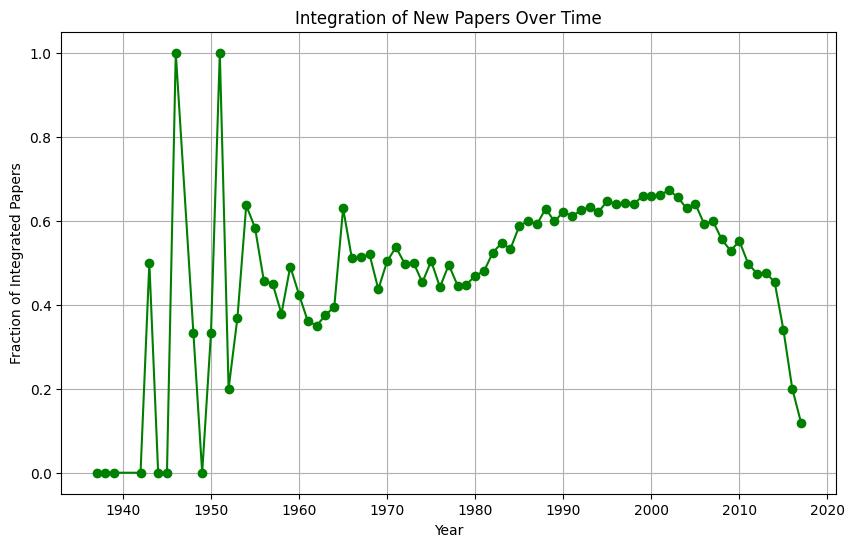

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast

def safe_parse_references(references):
    if isinstance(references, str):
        try:
            return ast.literal_eval(references)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(references, list):
        return references
    return []

data['parsed_references'] = data['references'].apply(safe_parse_references)
citation_graph = nx.DiGraph()
for _, row in data.iterrows():
    paper_id = row['id']
    paper_year = row['year']
    citation_graph.add_node(paper_id, year=paper_year)
    for ref_id in row['parsed_references']:
        citation_graph.add_edge(paper_id, ref_id)

print("Sample Node Attributes:")
print(list(citation_graph.nodes(data=True))[:5])

density_by_year = {}
for year in sorted(data['year'].unique()):
    yearly_nodes = [node for node, attr in citation_graph.nodes(data=True) if attr.get('year') == year]
    yearly_subgraph = citation_graph.subgraph(yearly_nodes)
    density_by_year[year] = nx.density(yearly_subgraph)


plt.figure(figsize=(10, 6))
plt.plot(list(density_by_year.keys()), list(density_by_year.values()), marker='o')
plt.title('Network Density Over Time')
plt.xlabel('Year')
plt.ylabel('Density')
plt.grid()
plt.show()

in_degree = dict(citation_graph.in_degree())
data['in_degree'] = data['id'].map(in_degree)

top_cited_papers = data[data['in_degree'] > data['in_degree'].quantile(0.95)]

print("\nTop Cited Papers:")
print(top_cited_papers[['id', 'title', 'in_degree', 'year']].sort_values(by='in_degree', ascending=False))

integration_over_time = {}
for year in sorted(data['year'].unique()):
    yearly_nodes = [node for node, attr in citation_graph.nodes(data=True) if attr.get('year') == year]
    new_connections = sum(1 for node in yearly_nodes if citation_graph.in_degree(node) > 0)
    integration_over_time[year] = new_connections / len(yearly_nodes) if len(yearly_nodes) > 0 else 0

plt.figure(figsize=(10, 6))
plt.plot(list(integration_over_time.keys()), list(integration_over_time.values()), marker='o', color='green')
plt.title('Integration of New Papers Over Time')
plt.xlabel('Year')
plt.ylabel('Fraction of Integrated Papers')
plt.grid()
plt.show()


PART2


In [ ]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import ast
from community import community_louvain
import matplotlib.pyplot as plt
author_graph = nx.Graph()

author_metadata = defaultdict(lambda: {'paper_ids': [], 'years': [], 'venues': []})
def safe_parse_authors(authors):
    if isinstance(authors, str):
        try:
            return ast.literal_eval(authors)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(authors, list):
        return authors
    return []
data['parsed_authors'] = data['authors'].apply(safe_parse_authors)
for _, row in data.iterrows():
    authors = row['parsed_authors']
    paper_id = row['id']
    year = row['year']
    venue = row['venue']

    for author in authors:
        author_metadata[author]['paper_ids'].append(paper_id)
        author_metadata[author]['years'].append(year)
        author_metadata[author]['venues'].append(venue)

    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            author_graph.add_edge(authors[i], authors[j])

for author in author_metadata:
    author_graph.add_node(author)
for author, metadata in author_metadata.items():
    if author in author_graph.nodes:
        author_graph.nodes[author].update(metadata)
partition = community_louvain.best_partition(author_graph)
for author, community in partition.items():
    author_graph.nodes[author]['community'] = community

communities = defaultdict(list)
for author, community in partition.items():
    communities[community].append(author)
print("\nTop 5 Communities:")
for i, (community_id, members) in enumerate(sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)[:5]):
    print(f"Community {i + 1} (Size: {len(members)}): {', '.join(members[:10])}...")  # Show first 10 members

# # Visualize the graph with communities
# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(author_graph, seed=42)
# colors = [partition[node] for node in author_graph.nodes()]
# nx.draw_networkx(
#     author_graph,
#     pos,
#     node_color=colors,
#     with_labels=False,
#     node_size=20,
#     cmap=plt.cm.rainbow,
# )
# plt.title("Author-Author Network with Communities")
# plt.show()


Top 5 Communities:
Community 1 (Size: 116129): Xing Zhou, Tao Fang, Lap-Pui Chau, Cyrus Shahabi, Shu-Yuen Didi Yao, Roger Zimmermann, Huaguang Zhang, Zhenwei Liu, Guang-Bin Huang, Zhanshan Wang...
Community 2 (Size: 66702): Genevi eve Paquin, Laurent Vuillon, Simonetta Balsamo, Gian–Luca Dei Rossi, Andrea Marin, Steven Euijong Whang, David Menestrina, Georgia Koutrika, Martin Theobald, Hector Garcia-Molina...
Community 3 (Size: 45662): Archana K. Singh, Hideki Asoh, Jocelyn Y. K. Aulin, Djordje Jeremic, Antoine Bossard, Keiichi Kaneko, Shietung Peng, Elon Rimon, Hiro Takahashi, Takeshi Kobayashi...
Community 4 (Size: 34310): Efraim Laksman, Håkan Lennerstad, Pietro Andreani, Ahmed Bader, Eylem Ekici, Daniele D. Giusto, Maurizio Murroni, Giulio Soro, Emilie Bosc, Patrick Le Callet...
Community 5 (Size: 29796): Olof Olsson, Philippe Hanhart, Touradj Ebrahimi, Elisabeth André, Peter Ingwersen, Chu-Ren Huang, Daniel Ferrés, Horacio Rodríguez, Hossein Sameti, Hisami Suzuki...


In [10]:
import pandas as pd
import networkx as nx
import ast
from collections import defaultdict
from community import community_louvain  # Louvain algorithm
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np



def safe_parse_authors(authors):
    if isinstance(authors, str):
        try:
            return ast.literal_eval(authors)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(authors, list):
        return authors
    return []

data['parsed_authors'] = data['authors'].apply(safe_parse_authors)
sample_fraction = 0.005
sampled_data = data.sample(frac=sample_fraction, random_state=42)
author_graph = nx.Graph()
author_metadata = defaultdict(lambda: {'paper_ids': [], 'years': [], 'venues': []})

for _, row in sampled_data.iterrows():
    authors = row['parsed_authors']
    paper_id = row['id']
    year = row['year']
    venue = row['venue']
    for author in authors:
        author_metadata[author]['paper_ids'].append(paper_id)
        author_metadata[author]['years'].append(year)
        author_metadata[author]['venues'].append(venue)
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            author_graph.add_edge(authors[i], authors[j])
for author, metadata in author_metadata.items():
    if author in author_graph.nodes:
        author_graph.nodes[author].update(metadata)

# 1. Louvain Algorithm
louvain_partition = community_louvain.best_partition(author_graph)
louvain_communities = defaultdict(list)
for author, community in louvain_partition.items():
    louvain_communities[community].append(author)

print("\nLouvain Communities:")
for i, (community, members) in enumerate(louvain_communities.items()):
    print(f"Community {i + 1} (Size: {len(members)}): {', '.join(members[:5])}...")


Louvain Communities:
Community 1 (Size: 11): Maria G. Koziri, Panos Papadopoulos, Nikos Tziritas, Antonios N. Dadaliaris, Thanasis Loukopoulos...
Community 2 (Size: 2): Luís Fernando Orleans, Geraldo Zimbrão...
Community 3 (Size: 2): Artur Zawadzki, Marek Gorgon...
Community 4 (Size: 3): Yadong Wang, Jiankang Wu, Ashraf A. Kassim...
Community 5 (Size: 3): Arber Murturi, Burak Kantarci, Sema Oktug...
Community 6 (Size: 3): Daan Zhu, Moe Razaz, Richard A. Lee...
Community 7 (Size: 4): Yong Zhang, Dongjin Kwon, Kilian M. Pohl, Yishu Zhai...
Community 8 (Size: 5): Minda Yang, Sameer A. Sheth, Catherine A. Schevon, Guy M. McKhann, Nima Mesgarani...
Community 9 (Size: 3): Stephen E. Chick, Sada Soorapanth, James S. Koopman...
Community 10 (Size: 5): Nikolaos Vernadakis, Andreas Avgerinos, Eleni Zetou, Maria Giannousi, Efthimis Kioumourtzoglou...
Community 11 (Size: 3): Kaibo Wang, Xingshe Zhou, Shandan Zhou...
Community 12 (Size: 2): Jin-Long Wang, Shih-Ping Huang...
Community 13 (Size: 7):

 Find the author communities in this network using a fitting clustering algorithm. You a
allowed to use any algorithm, as long as the results make sense (Louvain, Walktrap,
Hierarchical, Spectral, Newman, etc.). You must train 3 clustering algorithms

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Spectral Clustering Communities:
Community 1 (Size: 1525): Maria G. Koziri, Panos Papadopoulos, Nikos Tziritas, Antonios N. Dadaliaris, Thanasis Loukopoulos...
Community 2 (Size: 203): Artur Zawadzki, Marek Gorgon, Chia-Yen Chen, Radim Sara, Chih-Lin Chi...
Community 3 (Size: 1102): Arber Murturi, Burak Kantarci, Sema Oktug, Daan Zhu, Moe Razaz...
Community 4 (Size: 61): Nicholas R. Howe, Andreas Fischer, Baptiste Wicht, Marc Conrad, Tim French...
Community 5 (Size: 113): J. Jesu Vedha Nayahi, V. Kavitha, Deepika Saini, Sanjeev Kumar, Fawang Liu...


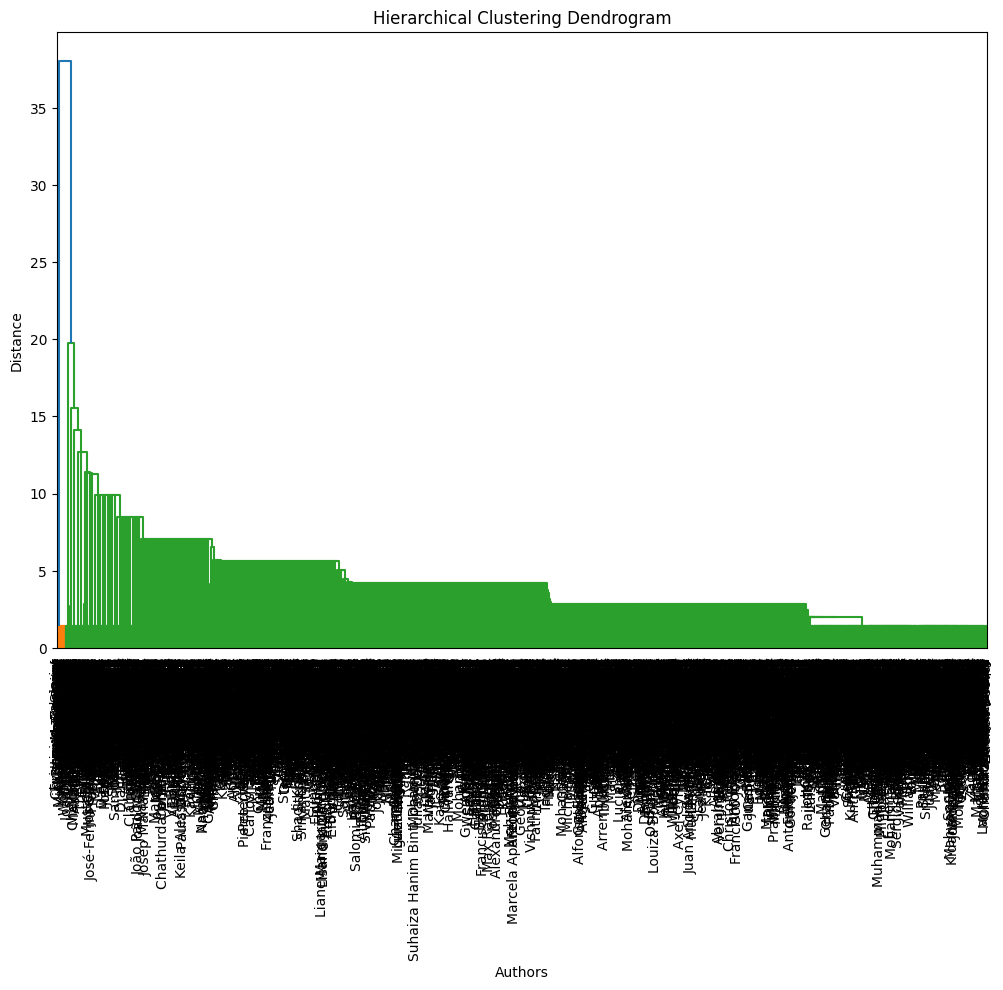


Hierarchical Clustering Communities:
Community 1 (Size: 2938): Maria G. Koziri, Panos Papadopoulos, Nikos Tziritas, Antonios N. Dadaliaris, Thanasis Loukopoulos...
Community 2 (Size: 15): Cheryl H. Porter, Chris Villalobos, Dean P. Holzworth, Roger Nelson, Jeffrey W. White...
Community 3 (Size: 11): Seydou Traoré, Abdrahamane Anne, Aly Khalifa, S. Bosomprah, F. Caroline...
Community 4 (Size: 28): Rolf Apweiler, Terri K. Attwood, Amos Marc Bairoch, Alex Bateman, Ewan Birney...
Community 5 (Size: 12): Lambert Schaelicke, John B. Carter, Wilson C. Hsieh, Mark R. Swanson, Lixin Zhang...


In [7]:
import pandas as pd
import networkx as nx
import ast
from collections import defaultdict
from community import community_louvain  # Louvain algorithm
from sklearn.cluster import SpectralClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np



def safe_parse_authors(authors):
    if isinstance(authors, str):
        try:
            return ast.literal_eval(authors)
        except (ValueError, SyntaxError):
            return []
    elif isinstance(authors, list):
        return authors
    return []


data['parsed_authors'] = data['authors'].apply(safe_parse_authors)
sample_fraction = 0.001
sampled_data = data.sample(frac=sample_fraction, random_state=42)
author_graph = nx.Graph()
author_metadata = defaultdict(lambda: {'paper_ids': [], 'years': [], 'venues': []})

for _, row in sampled_data.iterrows():
    authors = row['parsed_authors']
    paper_id = row['id']
    year = row['year']
    venue = row['venue']
    for author in authors:
        author_metadata[author]['paper_ids'].append(paper_id)
        author_metadata[author]['years'].append(year)
        author_metadata[author]['venues'].append(venue)
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            author_graph.add_edge(authors[i], authors[j])
for author, metadata in author_metadata.items():
    if author in author_graph.nodes:
        author_graph.nodes[author].update(metadata)

# 1. Louvain Algorithm
louvain_partition = community_louvain.best_partition(author_graph)
louvain_communities = defaultdict(list)
for author, community in louvain_partition.items():
    louvain_communities[community].append(author)

# print("\nLouvain Communities:")
# for i, (community, members) in enumerate(louvain_communities.items()):
#     print(f"Community {i + 1} (Size: {len(members)}): {', '.join(members[:5])}...")

# 2. Spectral Clustering
adj_matrix = nx.to_numpy_array(author_graph)

spectral_clustering = SpectralClustering(
    n_clusters=5,
    affinity='precomputed',
    random_state=42
)
spectral_labels = spectral_clustering.fit_predict(adj_matrix)
spectral_communities = defaultdict(list)
for author, label in zip(author_graph.nodes(), spectral_labels):
    spectral_communities[label].append(author)

print("\nSpectral Clustering Communities:")
for i, (community, members) in enumerate(spectral_communities.items()):
    print(f"Community {i + 1} (Size: {len(members)}): {', '.join(members[:5])}...")

# 3. Hierarchical Clustering
dist_matrix = 1 - adj_matrix
linkage_matrix = linkage(dist_matrix, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=list(author_graph.nodes()), leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Authors")
plt.ylabel("Distance")
plt.show()
hierarchical_labels = fcluster(linkage_matrix, t=5, criterion='maxclust')  # Extract 5 clusters
hierarchical_communities = defaultdict(list)
for author, label in zip(author_graph.nodes(), hierarchical_labels):
    hierarchical_communities[label].append(author)

print("\nHierarchical Clustering Communities:")
for i, (community, members) in enumerate(hierarchical_communities.items()):
    print(f"Community {i + 1} (Size: {len(members)}): {', '.join(members[:5])}...")


In [ ]:
import networkx as nx
import numpy as np
from collections import defaultdict

def evaluate_clustering_coefficient(graph, communities):
    coefficients = []
    for community, members in communities.items():
        subgraph = graph.subgraph(members)
        if len(subgraph) > 1:
            coeff = nx.average_clustering(subgraph)
            coefficients.append(coeff)
    return np.mean(coefficients) if coefficients else 0

louvain_communities = defaultdict(list)
for author, community in louvain_partition.items():
    louvain_communities[community].append(author)
louvain_clustering_coefficient = evaluate_clustering_coefficient(author_graph, louvain_communities)
print(f"Louvain Clustering Coefficient: {louvain_clustering_coefficient:.4f}")

Louvain Clustering Coefficient: 0.6696


Evaluate your clustering algorithm using the clustering coefficient and find the
clustering algorithm from the 3 clustering algorithms.

In [8]:
import networkx as nx
import numpy as np
from collections import defaultdict
def evaluate_clustering_coefficient(graph, communities):
    coefficients = []
    for community, members in communities.items():
        subgraph = graph.subgraph(members)
        if len(subgraph) > 1:
            coeff = nx.average_clustering(subgraph)
            coefficients.append(coeff)
    return np.mean(coefficients) if coefficients else 0

# 1. Louvain Clustering
louvain_communities = defaultdict(list)
for author, community in louvain_partition.items():
    louvain_communities[community].append(author)
louvain_clustering_coefficient = evaluate_clustering_coefficient(author_graph, louvain_communities)
print(f"Louvain Clustering Coefficient: {louvain_clustering_coefficient:.4f}")

# 2. Spectral Clustering
spectral_communities = defaultdict(list)
for author, label in zip(author_graph.nodes(), spectral_labels):
    spectral_communities[label].append(author)
spectral_clustering_coefficient = evaluate_clustering_coefficient(author_graph, spectral_communities)
print(f"Spectral Clustering Coefficient: {spectral_clustering_coefficient:.4f}")

# 3. Hierarchical Clustering
hierarchical_communities = defaultdict(list)
for author, label in zip(author_graph.nodes(), hierarchical_labels):
    hierarchical_communities[label].append(author)
hierarchical_clustering_coefficient = evaluate_clustering_coefficient(author_graph, hierarchical_communities)
print(f"Hierarchical Clustering Coefficient: {hierarchical_clustering_coefficient:.4f}")
print("\nClustering Algorithm Comparison:")
print(f"Louvain: {louvain_clustering_coefficient:.4f}")
print(f"Spectral: {spectral_clustering_coefficient:.4f}")
print(f"Hierarchical: {hierarchical_clustering_coefficient:.4f}")
best_algorithm = max(
    {
        "Louvain": louvain_clustering_coefficient,
        "Spectral": spectral_clustering_coefficient,
        "Hierarchical": hierarchical_clustering_coefficient,
    },
    key=lambda x: {
        "Louvain": louvain_clustering_coefficient,
        "Spectral": spectral_clustering_coefficient,
        "Hierarchical": hierarchical_clustering_coefficient,
    }[x]
)
print(f"\nBest Clustering Algorithm Based on Clustering Coefficient: {best_algorithm}")


Louvain Clustering Coefficient: 0.6703
Spectral Clustering Coefficient: 0.5786
Hierarchical Clustering Coefficient: 0.9597

Clustering Algorithm Comparison:
Louvain: 0.6703
Spectral: 0.5786
Hierarchical: 0.9597

Best Clustering Algorithm Based on Clustering Coefficient: Hierarchical


In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip install keybert
!pip install sentence-transformers

import csv
import pandas as pd
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import torch
print(torch.cuda.is_available())



sample_fraction = 0.005
sampled_data = data.sample(frac=sample_fraction, random_state=42)
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
kw_model = KeyBERT(model)
def extract_keywords(text, model, top_n=5):
    if isinstance(text, str) and len(text.strip()) > 0:
        keywords = model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=top_n)
        return [kw[0] for kw in keywords]
    return []
sampled_data['abstract_keywords'] = sampled_data['abstract'].apply(lambda x: extract_keywords(x, kw_model))
sampled_data['title_keywords'] = sampled_data['title'].apply(lambda x: extract_keywords(x, kw_model))
sampled_data['combined_keywords'] = sampled_data.apply(
    lambda row: list(set(row['abstract_keywords'] + row['title_keywords'])),
    axis=1
)
print("\nSample Paper Keywords:")
print(sampled_data[['title', 'combined_keywords']].head(30))


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
True


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Sample Paper Keywords:
                                                    title  \
987231  Slice-based parallelization in HEVC encoding: ...   
79954   MIDAS: A Middleware for Information Systems wi...   
567130  Automatically controlled pan-tilt smart camera...   
500891  Particle Filter for Visual Tracking Using Mult...   
55399    A reference model for crowdsourcing as a service   

                                        combined_keywords  
987231  [alternative hevc, hevc, hevc using, paralleli...  
79954   [middleware information, qos concerns, isolati...  
567130  [analysis camera, smart camera, camera device,...  
500891  [particle filter, tracking using, visual track...  
55399   [workflow crowdsourcing, mobile crowdsourcing,...  


Associate each paper with the corresponding community of authors. A paper might be in
two or more communities, so make sure to handle this correctly.


In [ ]:
author_paper_map = defaultdict(list)

for _, row in sampled_data.iterrows():
    for author in row['parsed_authors']:
        author_paper_map[author].append(row['combined_keywords'])
community_keywords = defaultdict(set)

for community_id, members in louvain_communities.items():
    for author in members:
        if author in author_paper_map:
            for keywords in author_paper_map[author]:
                community_keywords[community_id].update(keywords)
community_keywords = {community_id: list(keywords) for community_id, keywords in community_keywords.items()}
print("\nCommunity Keywords:")
for community_id, keywords in community_keywords.items():
    print(f"Community {community_id}: {', '.join(keywords[:10])}...")




Community Keywords:
Community 0: matrix multiplication, hevc using, matrix powers, adaptation distributed, overhead hevc, parallel algorithms, scalable parallel, parallelization hevc, based parallelization, video coding...
Community 1: middleware information, qos concerns, isolation concurrency, middleware, midas middleware, storage engine, systems qos, database servers, minimizes transactions, concurrency...
Community 2: analysis camera, smart camera, camera fpga, camera device, fpga based, tracking moving, tilt smart, controlled camera, position camera, orientation camera...
Community 3: particle filter, tracking using, visual tracking, tracking, bayesian filtering, visual track, track ing, cameras overlapping, multiple cameras...
Community 4: crowdsourcing service, crowdsourcing development, service, workflow crowdsourcing, mobile crowdsourcing, reference model, crowdsourcing services, crowdsourcing, model crowdsourcing...
Community 5: microscopy, deconvolution introduced, landwebe

Associate each paper with the corresponding community of authors. A paper might be in
two or more communities, so make sure to handle this correctly.


In [ ]:
from collections import defaultdict
author_to_community = defaultdict(set)

for community_id, authors in louvain_communities.items():
    for author in authors:
        author_to_community[author].add(community_id)
paper_community_mapping = defaultdict(set)

for _, row in sampled_data.iterrows():
    paper_id = row['id']
    paper_authors = row['parsed_authors']
    for author in paper_authors:
        if author in author_to_community:
            paper_community_mapping[paper_id].update(author_to_community[author])

sampled_data['associated_communities'] = sampled_data['id'].map(paper_community_mapping).apply(lambda x: list(x) if x else [])
print("\nSample Papers with Associated Communities:")
print(sampled_data[['id', 'title', 'associated_communities']].head(30))






Sample Papers with Associated Communities:
                                          id  \
987231  3e5ef05b-bb89-4717-bfc3-74a467529ded   
79954   653894e3-b581-412c-ae3f-71d267b0ea9d   
567130  0ba8b19f-9659-453f-8deb-50b87e26e41f   
500891  f12c84ba-82a9-4835-b5fa-5e6715b1b6b3   
55399   5d197014-1fbb-40d8-8223-378dea0d4a30   
135049  7790685d-525b-4f64-bd58-12d8cea683c8   
733378  08f4b403-7400-48d6-981b-6e76424ac967   
732057  04adad30-8b65-4dc2-84bd-be8d7541d0e0   
51333   5bb77780-134d-4cc8-af42-fc237bdd1210   
731479  02bf09d4-b4ac-4d27-a5a7-3f4c6b362777   
399758  cf6c9cff-538a-436c-8d74-e19630de9336   
401397  cff8e5e4-5e60-4200-80d2-9cc4c6b44f24   
855485  6b00f30a-5f14-4697-8d98-5e33ba342904   
858884  e5f3746f-1826-4936-92f3-4402d4067d14   
503247  f1f926dd-985c-481a-8cc1-ff2f7d81c3dd   
864741  bf0ef3ed-4d34-450c-9844-2d99b93a4f1c   
35032   5648caff-c2bf-45df-a66f-af9cb5f56545   
995703  b837ab28-e758-41bc-aa22-00510ca97494   
376761  c7d1b7d0-ece8-4479-a2ec-f09c71c64f37

. Aggregate the keywords of each paper from each community to get the keywords of the
community. Explain your aggregation method, and report the keywords of each
community in your report.


In [ ]:
community_keywords = defaultdict(set)

for paper_id, communities in paper_community_mapping.items():
    paper_keywords = sampled_data.loc[sampled_data['id'] == paper_id, 'combined_keywords'].values
    if len(paper_keywords) > 0:
        paper_keywords = paper_keywords[0]
    else:
        paper_keywords = []

    for community_id in communities:
        community_keywords[community_id].update(paper_keywords)
community_keywords = {community_id: list(keywords) for community_id, keywords in community_keywords.items()}
print("\nCommunity Keywords:")
for community_id, keywords in community_keywords.items():
    print(f"Community {community_id}: {', '.join(keywords[:10])}...")  # Show top 10 keywords


Community Keywords:
Community 0: matrix multiplication, hevc using, matrix powers, adaptation distributed, overhead hevc, parallel algorithms, scalable parallel, parallelization hevc, based parallelization, video coding...
Community 1: middleware information, qos concerns, isolation concurrency, middleware, midas middleware, storage engine, systems qos, database servers, minimizes transactions, concurrency...
Community 2: analysis camera, smart camera, camera fpga, camera device, fpga based, tracking moving, tilt smart, controlled camera, position camera, orientation camera...
Community 3: particle filter, tracking using, visual tracking, tracking, bayesian filtering, visual track, track ing, cameras overlapping, multiple cameras...
Community 4: crowdsourcing service, crowdsourcing development, service, workflow crowdsourcing, mobile crowdsourcing, reference model, crowdsourcing services, crowdsourcing, model crowdsourcing...
Community 5: microscopy, deconvolution introduced, landwebe

Give each community a name, and explain how you came to choose these names

In [ ]:
from collections import Counter
def generate_community_name(community_id, keywords, top_n=3):
    """
    Selects the most common keywords from a community to generate a meaningful name.
    """
    if not keywords:
        return f"Community {community_id}"
    keyword_counts = Counter(keywords)
    top_keywords = [kw[0] for kw in keyword_counts.most_common(top_n)]
    return ", ".join(top_keywords)
community_names = {community_id: generate_community_name(community_id, keywords)
                   for community_id, keywords in community_keywords.items()}
def get_community_names(community_ids):
    return [community_names[cid] for cid in community_ids if cid in community_names]
sampled_data['community_names'] = sampled_data['associated_communities'].apply(get_community_names)
print("\nSample Papers with Community Names:")
print(sampled_data[['id', 'title', 'community_names']].head(60))



Sample Papers with Community Names:
                                          id  \
987231  3e5ef05b-bb89-4717-bfc3-74a467529ded   
79954   653894e3-b581-412c-ae3f-71d267b0ea9d   
567130  0ba8b19f-9659-453f-8deb-50b87e26e41f   
500891  f12c84ba-82a9-4835-b5fa-5e6715b1b6b3   
55399   5d197014-1fbb-40d8-8223-378dea0d4a30   
135049  7790685d-525b-4f64-bd58-12d8cea683c8   
733378  08f4b403-7400-48d6-981b-6e76424ac967   
732057  04adad30-8b65-4dc2-84bd-be8d7541d0e0   
51333   5bb77780-134d-4cc8-af42-fc237bdd1210   
731479  02bf09d4-b4ac-4d27-a5a7-3f4c6b362777   
399758  cf6c9cff-538a-436c-8d74-e19630de9336   
401397  cff8e5e4-5e60-4200-80d2-9cc4c6b44f24   
855485  6b00f30a-5f14-4697-8d98-5e33ba342904   
858884  e5f3746f-1826-4936-92f3-4402d4067d14   
503247  f1f926dd-985c-481a-8cc1-ff2f7d81c3dd   
864741  bf0ef3ed-4d34-450c-9844-2d99b93a4f1c   
35032   5648caff-c2bf-45df-a66f-af9cb5f56545   
995703  b837ab28-e758-41bc-aa22-00510ca97494   
376761  c7d1b7d0-ece8-4479-a2ec-f09c71c64f37   
811

PART 2.3

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
Sampled 5000 rows out of 1000000 total rows.
                                                 abstract  \
987231  The new video coding standard HEVC (High Effic...   
79954   One of the most difficult tasks in the design ...   
567130  An intelligent, automatically controlled camer...   
500891  This article proposes an approach for visual t...   
55399   Online and mobile crowdsourcing services call ...   

                                                  authors  n_citation  \
987231  ['Maria G. Koziri', 'Panos Papadopoulos', 'Nik...          50   
79954        ['Luís Fernando Orleans', 'Geraldo Zimbrão']           1   
567130                 ['Artur Zawadzki', 'Marek Gorgon']           2   
500891  ['Yadong Wang', 'Jiankang Wu', 'Ashraf A. Kass...          15   
55399   ['Arber Murturi', 'Burak Kantarci', 'Sema Oktug']           5   

                                               references  \
9872

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Reducing dimensions for visualization...


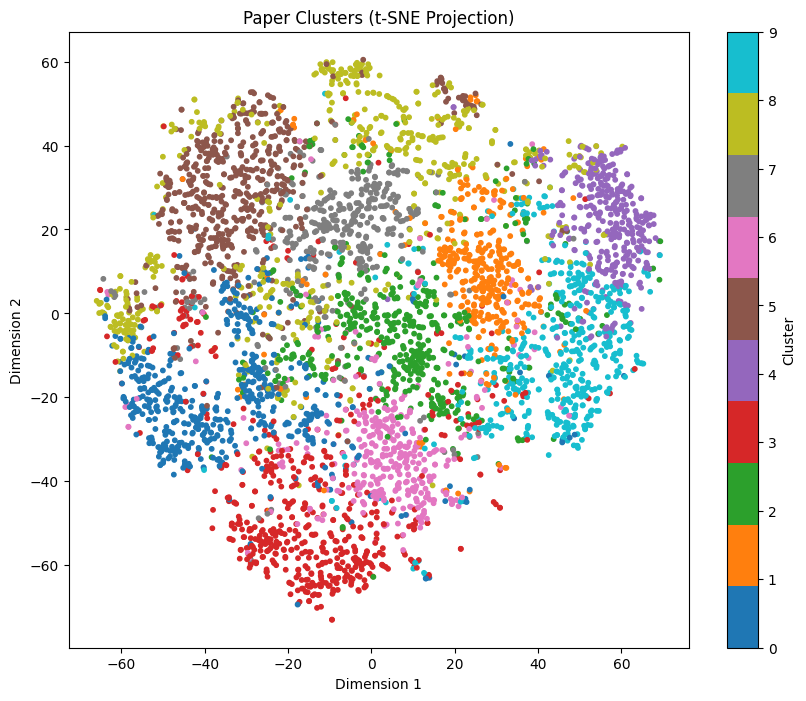


Sample Papers by Clusters:

Cluster 0:
                                          id  \
659806  e2435946-638d-40e9-9bae-7ed03117b5fb   
219339  938351fd-b731-4c58-85d2-e0b453b455b6   
943378  5fcb51d6-4986-424a-864d-e134822e6879   
321941  b5aedf69-ee1d-40fc-bf4e-94b5f9caa2cb   
212423  9134dac4-cf8e-4573-9ae8-a9f7f6f3deae   

                                                    title  
659806  Simplified Relative Citation Ratio for Static ...  
219339  An Architecture of a Web-Based Collaborative I...  
943378        Query-friendly compression of graph streams  
321941  Translating Named Entities Using Monolingual a...  
212423  Language Classification and Segmentation of No...  

Cluster 1:
                                          id  \
987231  3e5ef05b-bb89-4717-bfc3-74a467529ded   
399758  cf6c9cff-538a-436c-8d74-e19630de9336   
2085    4b64a593-b393-4787-81fd-2d71e6b15274   
529927  faddb485-02ee-48dc-971d-329a9f731034   
330797  b89f30e1-0984-4258-9af1-7da848fad33b   

          

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip install keybert
!pip install sentence-transformers

import pandas as pd
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import defaultdict

sample_fraction = 0.005
sampled_data = data.sample(frac=sample_fraction, random_state=42)

# Display sample size
print(f"Sampled {len(sampled_data)} rows out of {len(data)} total rows.")
print(sampled_data.head())


model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
kw_model = KeyBERT(model)

def extract_keywords(text, model, top_n=5):
    if isinstance(text, str) and len(text.strip()) > 0:
        keywords = model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=top_n)
        return [kw[0] for kw in keywords]
    return []
print("Extracting keywords for sampled data...")
sampled_data['abstract_keywords'] = sampled_data['abstract'].apply(lambda x: extract_keywords(x, kw_model))
sampled_data['title_keywords'] = sampled_data['title'].apply(lambda x: extract_keywords(x, kw_model))

sampled_data['combined_keywords'] = sampled_data.apply(
    lambda row: list(set(row['abstract_keywords'] + row['title_keywords'])),
    axis=1
)

print("\nSample Paper Keywords:")
print(sampled_data[['title', 'combined_keywords']].head())
def prepare_text(row):
    """
    Combines title, abstract, and keywords into a single enriched text.
    """
    title = row['title'] if isinstance(row['title'], str) else ""
    abstract = row['abstract'] if isinstance(row['abstract'], str) else ""
    keywords = " ".join(row['combined_keywords']) if isinstance(row['combined_keywords'], list) else ""
    return f"{title}. {abstract}. {keywords}"

sampled_data['enriched_text'] = sampled_data.apply(prepare_text, axis=1)
print("Generating embeddings...")
embeddings = model.encode(sampled_data['enriched_text'].tolist(), show_progress_bar=True)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
sampled_data['cluster'] = kmeans.fit_predict(embeddings)
print("Reducing dimensions for visualization...")
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=sampled_data['cluster'],
    cmap='tab10',
    s=10
)
plt.title("Paper Clusters (t-SNE Projection)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label="Cluster")
plt.show()
print("\nSample Papers by Clusters:")
for cluster_id in range(num_clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_papers = sampled_data[sampled_data['cluster'] == cluster_id]
    print(cluster_papers[['id', 'title']].head())
cluster_counts = sampled_data['cluster'].value_counts()
print("\nCluster Distribution:")
print(cluster_counts)


In [ ]:
!pip install scikit-learn

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

import numpy as np
dbi_score = davies_bouldin_score(embeddings, sampled_data['cluster'])
print(f"\nDavies-Bouldin Index (DBI): {dbi_score:.4f} (Lower is better)")
sample_size = len(sampled_data)
silhouette_sample_indices = np.random.choice(len(sampled_data), sample_size, replace=False)
silhouette_values = silhouette_samples(embeddings, sampled_data['cluster'])
silhouette_avg = np.mean(silhouette_values[silhouette_sample_indices])

print(f"\nOptimized Silhouette Score (Sampled {sample_size} points, considering full data): {silhouette_avg:.4f} (Higher is better)")


Davies-Bouldin Index (DBI): 4.2225 (Lower is better)

Optimized Silhouette Score (Sampled 5000 points, considering full data): 0.0314 (Higher is better)


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

unique_venues = sampled_data['venue'].unique()
print(f"\nUnique Venues ({len(unique_venues)}):")
print(unique_venues)
mlb = MultiLabelBinarizer()
venue_labels = mlb.fit_transform(sampled_data['venue'].apply(lambda x: [x] if isinstance(x, str) else []))
cluster_labels = sampled_data['cluster'].values
if venue_labels.shape[0] != len(cluster_labels):
    raise ValueError("Mismatch in dimensions between clusters and venue labels.")
jaccard_scores = []
for i in range(venue_labels.shape[1]):
    venue_column = venue_labels[:, i]
    jaccard_index = jaccard_score(cluster_labels, venue_column, average='macro')
    jaccard_scores.append(jaccard_index)

mean_jaccard_score = np.mean(jaccard_scores)
print(f"\nMean Jaccard Similarity Index between clusters and venues: {mean_jaccard_score:.4f}")



Unique Venues (1274):
['multimedia signal processing'
 'international conference on enterprise information systems'
 'Journal of Systems Architecture' ... 'American Mathematical Monthly'
 'Frontiers in ICT' 'digital game and intelligent toy enhanced learning']

Mean Jaccard Similarity Index between clusters and venues: 0.0117


Part3


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
test_data_path = "/content/drive/My Drive/test_data.csv"
test_data = pd.read_csv(test_data_path)
test_data = test_data.dropna(subset=['title', 'abstract', 'Year', 'num_citations'])
test_data['num_citations'] = test_data['num_citations'].astype(int)

print("✅ Test Data Loaded Successfully!")
print(f"🔹 Total Test Samples: {len(test_data)}")
print("\n🔹 Sample Test Data:")
print(test_data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Test Data Loaded Successfully!
🔹 Total Test Samples: 7812

🔹 Sample Test Data:
                                         ID  \
1  4510a1b4f561aa16b5d76b896fc0a493c40b7b05   
2  05c189f91383a62ca05078eee020fc2a091e6698   
3  7f2386b92821a1b7e01b58995f76b530300d7783   
4  4b586eb9aad3459fbd63e1a25be5244b44ccf960   
5  fe6aad311a588519aa3b464397ae729d391a3625   

                                               title  Year  num_citations  \
1  A Full Level-of-Detail Specification for 3D Bu...  2018             53   
2    A Measure-Theoretic Foundation for Data Quality  2018             25   
3  Modeling of a piled foundation in a Femap with...  2020              7   
4  Influencing Factors of Motion Responses for La...  2019              9   
5  General Multi-Fidelity Framework for Training ...  2019             30   

                                            

In [ ]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

sample_size = min(len(data), 15000)
sampled_data = data.sample(n=sample_size, random_state=42)
sampled_data['abstract'] = sampled_data['abstract'].fillna("").astype(str)
X_data = sampled_data['abstract'].tolist()
y_data = sampled_data['n_citation'].astype(int)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print("Generating embeddings for training data...")
embeddings = model.encode(X_data, show_progress_bar=True)
X_train, X_val, y_train, y_val = train_test_split(
    embeddings, y_data, train_size=12000, test_size=3000, random_state=42
)
print("Training Data Preprocessed!")
print(f"Train Samples: {len(X_train)}, Test Samples: {len(X_val)}")


Generating embeddings for training data...


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Training Data Preprocessed!
Train Samples: 12000, Test Samples: 3000


In [ ]:
!pip install tpot
from tpot import TPOTRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


tpot = TPOTRegressor(
    generations=5,
    population_size=20,
    verbosity=2,
    n_jobs=-1,
    random_state=42
)

tpot.fit(X_train, y_train)
best_model = tpot.fitted_pipeline_

print("\n Best Model Found by TPOT:")
print(best_model)
tpot.export('best_regression_model.py')


is_classifier
is_regressor
is_classifier


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tpot/decorators.py", line 57, in time_limited_call
    func(*args)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py", line 487, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "/usr/local/lib/pyth


Generation 1 - Current best internal CV score: -15408.169857941492

Generation 2 - Current best internal CV score: -15408.169857941492

Generation 3 - Current best internal CV score: -15408.169857941492

Generation 4 - Current best internal CV score: -15386.523198627581

Generation 5 - Current best internal CV score: -15386.523198627581

Best pipeline: RandomForestRegressor(Nystroem(input_matrix, gamma=0.5, kernel=rbf, n_components=8), bootstrap=True, max_features=0.05, min_samples_leaf=7, min_samples_split=14, n_estimators=100)

 Best Model Found by TPOT:
Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.5, n_components=8, random_state=42)),
                ('randomforestregressor',
                 RandomForestRegressor(max_features=0.05, min_samples_leaf=7,
                                       min_samples_split=14,
                                       random_state=42))])


In [ ]:
import numpy as np
import torch
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

param_grid = {
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [5, 7]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        }
    }
}

best_model, best_params, best_score = None, None, float('inf')

for model_name, config in param_grid.items():
    print(f"\n Running Optimized GridSearch for {model_name}...")

    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=2,
        scoring='neg_mean_squared_error',
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    if -grid_search.best_score_ < best_score:
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = -grid_search.best_score_

    print(f"\n Best parameters for {model_name}: {grid_search.best_params_}")
    print(f" Best MSE for {model_name}: {-grid_search.best_score_:.4f}")

print("\n Best Model Found:")
print(f" Model: {type(best_model).__name__}")
print(f"Parameters: {best_params}")

y_pred = best_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("\n Model Evaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


 Running Optimized GridSearch for GradientBoosting...
Fitting 2 folds for each of 8 candidates, totalling 16 fits

 Best parameters for GradientBoosting: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
 Best MSE for GradientBoosting: 20014.1549

 Running Optimized GridSearch for RandomForest...
Fitting 2 folds for each of 8 candidates, totalling 16 fits

 Best parameters for RandomForest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
 Best MSE for RandomForest: 18377.8784

 Best Model Found:
 Model: RandomForestRegressor
Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

 Model Evaluation Metrics:
RMSE: 83.1747
MAE: 40.0588
R² Score: -0.6419


In [ ]:
available_test_size = len(test_data)
test_size = min(3000, available_test_size)

test_data = test_data.sample(n=test_size, random_state=42)

test_data['abstract'] = test_data['abstract'].fillna("").astype(str)
test_data['num_citations'] = test_data['num_citations'].astype(int)
X_test_embeddings = model.encode(test_data['abstract'].tolist(), show_progress_bar=True)
y_test = test_data['num_citations'].values


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_tpot_pipeline = Pipeline(steps=[
    ('nystroem', Nystroem(gamma=0.5, kernel='rbf', n_components=8, random_state=42)),
    ('randomforestregressor', RandomForestRegressor(
        bootstrap=True,
        max_features=0.05,
        min_samples_leaf=7,
        min_samples_split=14,
        n_estimators=100,
        random_state=42
    ))
])

print("Training TPOT-Selected RandomForest Model...")
best_tpot_pipeline.fit(X_train, y_train)
y_pred = best_tpot_pipeline.predict(X_test_embeddings)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n Model Performance on Crawled Test Data:")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

results_df = pd.DataFrame({
    "Actual Citations": y_val_actual,
    "Predicted Citations": y_pred
})
results_df.head(20)


Training TPOT-Selected RandomForest Model...

 Model Performance on Crawled Test Data:
RMSE (Root Mean Squared Error): 440.1746
MAE (Mean Absolute Error): 93.9885
R² Score: -0.0224


,Actual Citations,Predicted Citations
764015,1.0,48.429339
822808,20.0,47.662775
836090,50.0,34.755575
60912,122.0,40.928889
978063,50.0,63.006181
576953,1.0,38.012007
585731,50.0,42.905927
615581,0.0,33.234957
475637,1.0,36.613135
839929,0.0,30.971990


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    colsample_bytree=0.8,
    subsample=0.8,
    objective="reg:squarederror",
    random_state=42
)

print("Training XGBoost Regressor...")
xgb_model.fit(X_train, y_train_log)
y_pred_log = xgb_model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val_log)

rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
mae = mean_absolute_error(y_val_actual, y_pred)
r2 = r2_score(y_val_actual, y_pred)

print("\n Model Performance with XGBoost:")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


results_df = pd.DataFrame({
    "Actual Citations": y_val_actual,
    "Predicted Citations": y_pred
})
results_df.head(20)


Training XGBoost Regressor...

📊 Model Performance with XGBoost:
✅ RMSE (Root Mean Squared Error): 123.1483
✅ MAE (Mean Absolute Error): 32.8007
✅ R² Score: -0.0304


,Actual Citations,Predicted Citations
764015,1.0,2.062268
822808,20.0,7.706326
836090,50.0,10.979347
60912,122.0,20.424091
978063,50.0,12.171082
576953,1.0,5.304145
585731,50.0,8.939227
615581,0.0,6.703262
475637,1.0,11.065205
839929,0.0,2.062268


In [ ]:
!pip install lightgbm
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lgbm_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=42
)


print("Training LightGBM Regressor...")
lgbm_model.fit(X_train, y_train_log)
y_pred_log = lgbm_model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val_log)

rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
mae = mean_absolute_error(y_val_actual, y_pred)
r2 = r2_score(y_val_actual, y_pred)

print("\n Model Performance with LightGBM:")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

results_df = pd.DataFrame({
    "Actual Citations": y_val_actual,
    "Predicted Citations": y_pred
})

results_df.head(20)


🔄 Training LightGBM Regressor...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97918
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 384
[LightGBM] [Info] Start training from score 2.188849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📊 Model Performance with LightGBM:
✅ RMSE (Root Mean Squared Error): 123.4998
✅ MAE (Mean Absolute Error): 32.8441
✅ R² Score: -0.0363


,Actual Citations,Predicted Citations
764015,1.0,2.084499
822808,20.0,12.957464
836090,50.0,8.402867
60912,122.0,12.507732
978063,50.0,12.541244
576953,1.0,2.859069
585731,50.0,9.238611
615581,0.0,5.094810
475637,1.0,9.939477
839929,0.0,2.084499
